# LeagueRank: A game skill evaluatioin application
## <a name="introduction"></a>Introduction

Nowadays, League of Legends (LOL) is probably the most popular online MOBA game in the world, with over 67 million players every month. LOL is a real-time competing game, which requires skills and strategy. Thus, knowing about your ability and skills is important for people who want to reach a higher level, especially for the professional players. Currently, Riot Games (the producer of LOL) has only provided rank score to estimate the players integrated level. For specific champions' level, there's no official tools to precisely evaluate that. This project is aimed to reveal the players most frequently played champions' level and give players a guidance of how to horn his/her skills.

Basically it is a *** multiclass classification *** problem in machine learning.

![League of Legends](image/lol.jpg)

For background knowledge, there are some terminology that need to be clarified:
- **Summoner:** the player
- **Champion:** the character summoner uses during the game
- **Rank game:** LoL game includes rank game and unrank game, only would rank game be counted towards tier evaluation.
- **Tier:** the level a summoner is in currently. There are seven tiers currently, from low to high: bronze, silver, gold, platinum, diamond, master and challenger.
- **Division:** the sub-level a summoner is in. For example, bronze to diamond have 5 divisions, represented using Roman numbers (I-V), whereas master and challenger have only one division.
- **ADC:** attack damage carry (one of the most important roles in LOL game)

## Content

1. [introduction](#introduction)
2. [installing the library](#install)
3. [project architecture](#architecture)
    1. [data crawling](#crawl)
        1. [fetch summoner list](#summonerList)
        2. [fetch most frequently played champions](#mfpChampions)
    2. [data process, training and analysis](#train)
        1. [process raw data](#raw)
        2. [k-fold cross validation](#cross-validation)
        2. [K-Nearest Neighbors Model](#knn)
        3. [Support Vector Machine Model](#svm)
        4. [Convolutional Neural Network Model](#cnn)
    3. [data visualization](#visualization)
        1. [summoner prediction](#s-predict)
        2. [summoner analysis](#s-analysis)
        3. [champion popularity](#champion-popularity)

## <a name="install"></a>Installing the library

Before getting started, we need to prepare some libraries. The main package we use to crawl the LOL data is called ```riotwatcher```, which is a [Python library](https://github.com/pseudonym117/Riot-Watcher) built up with the API provided by Riot. Also we used many other libraries as we did in our assignments. Installing thoses libraries via ```pip```:

```pip install riotwatcher```

```pip install urllib2```

```pip install glob```

```pip install pickle```

```pip install wordcloud```

```pip install matplotlib```

```pip install pandas```

```pip install numpy```

```pip install sklearn```

```pip install keras ```

After you run all the installs, make sure the following commands work for you:

In [49]:
%matplotlib inline
import csv
import json
import os
import ujson
import urllib2
import glob
import pickle
import re
import time
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy as sp

from riotwatcher import RiotWatcher

To use the Riot api, one more important thing to do is to get your own API key. API key can be obtained from [here](https://developer.riotgames.com/). Note that normal developr API key has a narrow request limit, whereas production API key for commercial use has a looser requirement of request limit.

After getting your own API key, put it in the config dictionary below:

In [50]:
config = {
    'key': 'your key',
}

## <a name="architecture"></a>Project Architecture
### <a name="crawl"></a>Data Crawling

The architecture for data crawler is shown as follow:
![Data crawling architecture](image/RiotCrawler_arch.png)


*** Notice that the [LOL S7 version](http://na.leagueoflegends.com/en/news/game-updates/competitive/2017-ranked-season-kicks) was released on December 7th 2016. And the data crawled and used in this project were from the last version which is S6. And since the S7 version was just released several days ago, there are no available data from Riot Co. currently. So you might find that there are 404 errors if you want to crawl the data as we did. But don't worry. We provided the data we crawled of LOL S6 version for you to use in this project. ***

The process of crawling data could be simplified as follows: 
1) Get summoners list from LOL server;
2) For each summoner, get his/her top 3 frequently played champions;
3) Fetch each champion's game stats for 2016 season (latest entire season);
4) Put the fetched data into corresponding csv file for storage.

#### <a name="summonerList"></a>1. Fetch summoner list

First of all, we need to fetch the summoner information down. Riot has provided with the api to get summoner information by leagues. League is the partial data in a tier. For example, in gold tier, we have summoners in gold I, gold II, gold III, gold IV and gold V. The summoners in gold tier are divided into several leagues, each league contains summoners in all ranges.

The ```__init__``` method of ```RiotCrawler``` define the tiers, ```get_player_by_tier``` fetches the summoner list in different leagues according to the provided summoner ids. 

In [51]:
class RiotCrawler:
    def __init__(self, key):
        self.key = key
        self.w = RiotWatcher(key)
        self.tiers = {
            'bronze': [],
            'silver': [],
            'gold': [],
            'platinum': [],
            'diamond': [],
            'challenger': [],
            'master': [],
        }

    def get_player_by_tier(self, summoner_id):
        request_url = 'https://na.api.pvp.net/api/lol/na/v2.5/league/by-summoner/{}?api_key={}'.format(
            summoner_id, self.key
        )
        response = urllib2.urlopen(request_url)
        tier_info = ujson.loads(response.read())

        tier = tier_info[str(summoner_id)][0]['tier'].lower()
        entries = tier_info[str(summoner_id)][0]['entries']

        level = self.tiers[tier]
        for entry in entries:
            level.append(entry['playerOrTeamId'])

#         for l in level:
#             print 'summoner id: {}'.format(str(l))

```get_tier``` will return a divisioin dictionary, whose keys are the tier name, and values are the summoner id list in each tier. The results are printed in a human-readable format, categorized by tier.

In [52]:
def get_tier():
    # challenger: 77759242
    # platinum: 53381
    # gold: 70359816
    # silver: 65213225
    # bronze: 22309680
    # master: 22551130
    # diamond: 34570626
    player_ids = [70359816, 77759242, 53381, 65213225, 22309680, 22551130, 34570626]
    riot_crawler = RiotCrawler(config['key'])
    for player_id in player_ids:
        print 'start crawling id: {}'.format(player_id)
        try:
            riot_crawler.get_player_by_tier(player_id)
        except:
            continue
    return riot_crawler.tiers

tiers = get_tier()
for tier, rank_dict in tiers.iteritems():
    print '--- {} ---'.format(tier)
    for summoner in rank_dict:
        print 'summoner id: {}'.format(summoner)
    print '--- end of {} ---'.format(tier)

start crawling id: 70359816
start crawling id: 77759242
start crawling id: 53381
start crawling id: 65213225
start crawling id: 22309680
start crawling id: 22551130
start crawling id: 34570626


#### <a name="mfpChampions"></a>2. Fetch most frequently played champions

Since we already had a dictionary of all user ids mapping to all categories of ranks, we can now use those user ids to get the stats data of their most frequently used champions.

Riot gives us the API to get all champions that a user had used during the season. And the response will be in JSON format. After parsing the JSON response, what we need to do is to get the most frequently used champions which can represent a player's level. So we sort the champions list by the number of games that the player used this champioin (totalSessionsPlayed) in descending order. Notice that the first element in the list will always be the champion with id 0, which represents the stats data of all champions that the player used in the season. So we need to skip that.

After we filter out the top frequently used champions of a user, we need to save the stats data with the player's tier as the training label into a csv file. In this project, each champion has a corresponding csv file which records all the stats data of this hero with the tier of the player as the training data. Since there are hundreds of champions in League of Legend, we will have hundreds of csv files for training and each file uses the id of champions as the file name. If the file is already created, we will append more stats of this champion to the csv file.

In [53]:
class TopChampion:

    FIELD_NAMES = ['totalSessionsPlayed', 'totalSessionsLost', 'totalSessionsWon',
                   'totalChampionKills', 'totalDamageDealt', 'totalDamageTaken',
                   'mostChampionKillsPerSession', 'totalMinionKills', 'totalDoubleKills',
                   'totalTripleKills', 'totalQuadraKills', 'totalPentaKills',
                   'totalUnrealKills', 'totalDeathsPerSession', 'totalGoldEarned',
                   'mostSpellsCast', 'totalTurretsKilled', 'totalPhysicalDamageDealt',
                   'totalMagicDamageDealt', 'totalFirstBlood', 'totalAssists',
                   'maxChampionsKilled', 'maxNumDeaths', 'label']

    def __init__(self, key, player_id, label, n):
        self.label = label
        self.player_id = player_id
        self.key = key
        self.n = n
        self.top_champions = []
        pass

    def get_top_champions(self):
        self.top_champions[:] = []
        data = urllib2.urlopen(
            'https://na.api.pvp.net/api/lol/na/v1.3/stats/by-summoner/' +
            self.player_id +
            '/ranked?season=SEASON2016&api_key=' +
            self.key
        ).read()
        json_data = json.loads(data)
        champions = json_data['champions']
        champion_stats = []
        for champion in champions:
            champion_stat = champion['stats']
            champion_stat['id'] = champion['id']
            champion_stat['label'] = self.label
            champion_stats.append(champion_stat)
            pass
        self.top_champions = sorted(champion_stats,
                                    key=lambda x: x['totalSessionsPlayed'],
                                    reverse=True)[1:self.n + 1]
        return self.top_champions
        pass

    def save_top_champions(self, champion_id=None):
        for champion in self.top_champions:
            if not champion_id:
                champion_id = champion['id']
            file_name = './data/{}.csv'.format(champion['id'])
            if os.path.isfile(file_name):
                with open(file_name, 'a') as csvfile:
                    writer = csv.DictWriter(csvfile, fieldnames=self.FIELD_NAMES)
                    writer.writerow(
                        {
                            'totalSessionsPlayed': champion['totalSessionsPlayed'],
                            'totalSessionsLost': champion['totalSessionsLost'],
                            'totalSessionsWon': champion['totalSessionsWon'],
                            'totalChampionKills': champion['totalChampionKills'],
                            'totalDamageDealt': champion['totalDamageDealt'],
                            'totalDamageTaken': champion['totalDamageTaken'],
                            'mostChampionKillsPerSession': champion['mostChampionKillsPerSession'],
                            'totalMinionKills': champion['totalMinionKills'],
                            'totalDoubleKills': champion['totalDoubleKills'],
                            'totalTripleKills': champion['totalTripleKills'],
                            'totalQuadraKills': champion['totalQuadraKills'],
                            'totalPentaKills': champion['totalPentaKills'],
                            'totalUnrealKills': champion['totalUnrealKills'],
                            'totalDeathsPerSession': champion['totalDeathsPerSession'],
                            'totalGoldEarned': champion['totalGoldEarned'],
                            'mostSpellsCast': champion['mostSpellsCast'],
                            'totalTurretsKilled': champion['totalTurretsKilled'],
                            'totalPhysicalDamageDealt': champion['totalPhysicalDamageDealt'],
                            'totalMagicDamageDealt': champion['totalMagicDamageDealt'],
                            'totalFirstBlood': champion['totalFirstBlood'],
                            'totalAssists': champion['totalAssists'],
                            'maxChampionsKilled': champion['maxChampionsKilled'],
                            'maxNumDeaths': champion['maxNumDeaths'],
                            'label': champion['label']
                        }
                    )
                    pass
                pass
            else:
                with open(file_name, 'w') as csvfile:
                    writer = csv.DictWriter(csvfile, fieldnames=self.FIELD_NAMES)
                    writer.writeheader()
                    writer.writerow(
                        {
                            'totalSessionsPlayed': champion['totalSessionsPlayed'],
                            'totalSessionsLost': champion['totalSessionsLost'],
                            'totalSessionsWon': champion['totalSessionsWon'],
                            'totalChampionKills': champion['totalChampionKills'],
                            'totalDamageDealt': champion['totalDamageDealt'],
                            'totalDamageTaken': champion['totalDamageTaken'],
                            'mostChampionKillsPerSession': champion['mostChampionKillsPerSession'],
                            'totalMinionKills': champion['totalMinionKills'],
                            'totalDoubleKills': champion['totalDoubleKills'],
                            'totalTripleKills': champion['totalTripleKills'],
                            'totalQuadraKills': champion['totalQuadraKills'],
                            'totalPentaKills': champion['totalPentaKills'],
                            'totalUnrealKills': champion['totalUnrealKills'],
                            'totalDeathsPerSession': champion['totalDeathsPerSession'],
                            'totalGoldEarned': champion['totalGoldEarned'],
                            'mostSpellsCast': champion['mostSpellsCast'],
                            'totalTurretsKilled': champion['totalTurretsKilled'],
                            'totalPhysicalDamageDealt': champion['totalPhysicalDamageDealt'],
                            'totalMagicDamageDealt': champion['totalMagicDamageDealt'],
                            'totalFirstBlood': champion['totalFirstBlood'],
                            'totalAssists': champion['totalAssists'],
                            'maxChampionsKilled': champion['maxChampionsKilled'],
                            'maxNumDeaths': champion['maxNumDeaths'],
                            'label': champion['label']
                        }
                    )
                    pass
                pass
            pass
        pass
    pass

With the above class, now we can start crawling the stats data of all champions saving them to csv files by the following code. Notice that this process is pretty slow since we added the sleep methods in our code. Riot APIs have a limitation on the API calls rate. You cannot send more than 500 requests per 10 minutes. So everytime we send a request here, we sleep for 1 second to prevent error responses.

In [54]:
def main():
    tiers = get_tier()
    for tier, rank_dict in tiers.iteritems():
        print 'starting tier: {}'.format(tier)
        for summoner_id in rank_dict:
            print 'tier: {}, summoner id: {}'.format(tier, summoner_id)
            top_champion = TopChampion(config['key'], summoner_id, tier, 3)
            top_champion.get_top_champions()
            top_champion.save_top_champions()
            time.sleep(2)
        print 'end tier: {}'.format(tier)
main()

### <a name="train"></a>Data process, training and Analysis
#### <a name="raw"></a>Process raw data
Given the data we crawled from the previous part, now we need to process them and make sure that they can be used for later training part. Although we did a little processing work in crawling part to store data into csv format, we still need to group champions with the same type together. Here we take the role of "ADC" as an example in our project. We get all "ADC" champions from [this website](http://na.op.gg/champion/statistics).

In [55]:
adc_idx = [202, 42, 67, 222, 29, 51, 96, 81, 21, 6, 119, 15, 22, 236, 110, 18, 429]
dfs = list()
for adc_id in adc_idx:
    df = pd.read_csv('./data/{}.csv'.format(adc_id))
    dfs.append(df)
    pass
res = pd.concat(dfs, ignore_index=True, verify_integrity=True)
res.to_csv('./data/adc.csv', index=False)

Now we generate a new adc.csv file of all data we collected for the "ADC" champions. The next thing we need to do is to group the data of "ADC" of different levels together. Because later we will use k-fold cross validation on the data and we need to sample the same ratio of data of different levels for testing.

For the labels in crawled data, they are now python strings of "bronze", "silver", "gold", "platinum", "diamond", "challenger", "master". We mapped them from 0 to 6.

And since different features here have different scales of their values. For example, the "totalPhysicalDamageDealt" can be more than a 1000,000 while "totalSessionsLost" are mostly less than 100. So we also implement a normalize function which is used to scale each attribute into the same scale. Although this normalize function may not affect the final results and accuracies, it will definitely make training processes much faster.

Also, since we only focus on "ADC" champioins, we can drop some obviously not relavant features in this step.

In [56]:
def string_to_int(s):
    if s == 'bronze':
        return 0
    elif s == 'silver':
        return 1
    elif s == 'gold':
        return 2
    elif s == 'platinum':
        return 3
    elif s == 'diamond':
        return 4
    elif s == 'challenger':
        return 5
    else:
        return 6
    pass


def normalize(X):
    n, m = X.shape
    for i in range(m):
        col_max = np.max(X[:, i])
        col_min = np.min(X[:, i])
        col_delta = col_max - col_min + 1.0
        X[:, i] = (X[:, i] - col_min) / col_delta
        pass
    return X
    pass


def preprocess_adc(filename):
    df = pd.read_csv(filename, index_col=False)
    y = df['label'].map(lambda x: string_to_int(x)).as_matrix()
    df_t = df.drop(['totalDamageDealt', 'totalDamageTaken', 'totalDoubleKills', 'totalTripleKills',
                    'totalQuadraKills', 'totalPentaKills', 'totalUnrealKills', 'mostSpellsCast',
                    'totalTurretsKilled', 'totalMagicDamageDealt', 'totalFirstBlood'], axis=1)
    X = df_t.drop(['label'], axis=1).as_matrix().astype(float)
    X = normalize(X)
    uniques = np.unique(y)
    X_list = list()
    y_list = list()
    for unique in uniques:
        idxes = y == unique
        X_list.append(X[idxes])
        y_list.append(y[idxes])
        pass
    return X_list, y_list, df_t
    pass


#### <a name="cross-validation"></a>K-fold cross validation
To prevent overfitting and analyze our machine learning models, we applied K-fold cross validation here. The function below will return a list of k folds. Each fold in the list is a tuple of training X matrix, training y vector, test X matrix and test y vector.

In [57]:
def cross_validation(X_list, y_list, k=10):
    res = list()
    n = len(y_list)
    for i in range(k):
        X_tr_list = list()
        X_te_list = list()
        y_tr_list = list()
        y_te_list = list()
        for j in range(n):
            X_j = X_list[j]
            y_j = y_list[j]
            m = len(y_j)
            test_num = m / k
            test_start_idx = i * test_num
            test_end_idx = test_start_idx + test_num
            test_idx = range(test_start_idx, test_end_idx)
            train_idx = range(0, test_start_idx) + range(test_end_idx, m)
            X_tr_list.append(X_j[train_idx])
            y_tr_list.append(y_j[train_idx])
            X_te_list.append(X_j[test_idx])
            y_te_list.append(y_j[test_idx])
            pass
        X_tr = np.concatenate(X_tr_list)
        y_tr = np.concatenate(y_tr_list)
        X_te = np.concatenate(X_te_list)
        y_te = np.concatenate(y_te_list)
        res.append((X_tr, y_tr, X_te, y_te))
        pass
    return res
    pass

In [58]:
features_list, labels_list, df_avg = preprocess_adc('./data/adc.csv')
cf_list = cross_validation(features_list, labels_list)
k = len(cf_list)

#### <a name="knn"></a>K-Nearest Neighbors (KNN) Model
##### Why KNN model?
KNN was the first model that we came up with in this project, because it is a simple lazy learner and after dropping the irrelavant features we have don't have a lot of features for each instance of the data. Also we have a lot of training data, which should be enough for building a good KNN model. Moreover, the training process of KNN should be very fast and it can learn pretty complex target functions.

##### Model Design
The training process of KNN model is just simply storing every instance of training data. And the predicting process of KNN is just finding the k nearest points (instances of data) of current point in the memory and predicting the label of current point by asking the k nearest points to vote. The votes from the neighbors are simply their labels.

Moreover, we think the nearer neighbors should be more important than farther points in voting process. So we used the distance-weighted KNN model in our project.

The last thing to do is to decide the number of neighbors to consider in this model. Here we tried different k values in this model and compare the performances (accuracies) between models with different k values.

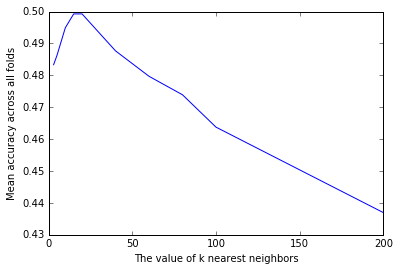

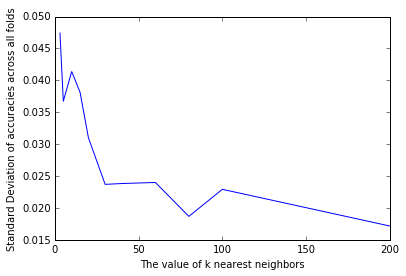

In [59]:
from sklearn.neighbors import KNeighborsClassifier

neighbor_nums = [3, 5, 10, 15, 20, 30, 40, 60, 80, 100, 200]
n = len(neighbor_nums)
knn_accuracies = np.zeros((k, n))
for i in range(k):
    X_tr, y_tr, X_te, y_te = cf_list[i]
    for j in range(n):
        knn = KNeighborsClassifier(n_neighbors=neighbor_nums[j], weights='distance')
        knn.fit(X_tr, y_tr)
        knn_accuracies[i, j] = knn.score(X_te, y_te)
        pass
    pass

knn_mean_accuracies = np.mean(knn_accuracies, axis=0)
knn_std_accuracies = np.std(knn_accuracies, axis=0)

plt.figure(1)
plt.plot(neighbor_nums, knn_mean_accuracies)
plt.xlabel('The value of k nearest neighbors')
plt.ylabel('Mean accuracy across all folds')
plt.figure(2)
plt.plot(neighbor_nums, knn_std_accuracies)
plt.xlabel('The value of k nearest neighbors')
plt.ylabel('Standard Deviation of accuracies across all folds')
plt.show()

##### KNN Analysis
From the figures above, we can see that the accuracy reaches its maximum when k is around 20. And after that the accuracy will go down. While the standard deviation across all folds is always going down with the value of k going up. This is an important property of KNN.

But the problem is that the accuracies are low no matter which k value we selected and no matter which fold we used. The maximum accuracy is around 50% with k = 20 in the KNN model.

We think this is probably caused by possible irrelavant features remaining and the noise in the training data and the KNN model is not good at dealing with such cases.

#### <a name="svm"></a>Support Vector Machine (SVM) Model
##### Why SVM model?
Since we failed using the KNN model in predicting results, we would like to try SVM model instead in this project. From the class we know that the key idea of the SVM model is maximizing the margins between different clusters of the data with different labels. It is a eager learner which may consume more time during training process compared with the KNN model. But it should be able to handle the irrelavant features and some noises in the training data.

##### Model Design
Here we used C-Support Vector Machine, which has an adjustable field 'C'. It is used to add penalty for misclassification. If the C value gets smaller the penalty will be smaller, but the margin will be larger. So it cannot be too large or too tiny. If it is too large, the margin will be too small which might lead to overfitting. And if it is too small, there will be too many misclassification which makes the accuracy lower. Here we make C to be 40, which is a fairly safe value to use.

Moreover, since there are a few kernel functions we can choose from for SVM, here we just tried all of them and compared their results.

In [60]:
from sklearn.svm import SVC

kernels = ['linear', 'poly', 'rbf', 'sigmoid']
kernel_num = len(kernels)
svm_accuracies = np.zeros((k, kernel_num))
for i in range(k):
    X_tr, y_tr, X_te, y_te = cf_list[i]
    for j in range(kernel_num):
        svm = SVC(C=40, kernel=kernels[j])
        svm.fit(X_tr, y_tr)
        svm_accuracies[i, j] = svm.score(X_te, y_te)
        pass
    pass


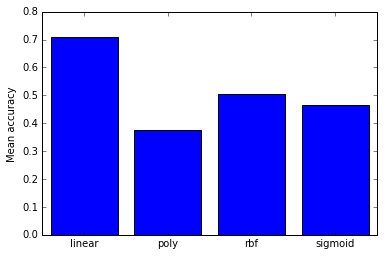

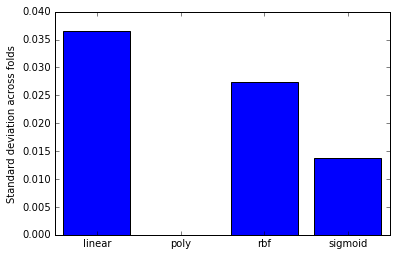

In [61]:
svm_mean_accuracies = np.mean(svm_accuracies, axis=0)
svm_std_accuracies = np.std(svm_accuracies, axis=0)
plt.figure(3)
plt.bar(range(4), svm_mean_accuracies, align='center')
plt.xticks(range(4), kernels)
plt.ylabel('Mean accuracy')
plt.figure(4)
plt.bar(range(4), svm_std_accuracies, align='center')
plt.xticks(range(4), kernels)
plt.ylabel('Standard deviation across folds')
plt.show()

##### SVM Analysis
From the results above we can see that the linear kernel works best in this project, because most of the features are linear to the labels. For example, players at higher level should win more games with their champion, so the total sessions won should be in linear relationship to the level the player at.

The maximum accuracy can be around 70% in this project. It looks pretty good since this is a multiclass classification problem in real world. But we are not satisfied with this result. We will try using Convolutional Neural Network to achieve even better performance.

#### <a name="cnn"></a>Convolutional Neural Network (CNN) Model
##### Why CNN Model?

Compared with KNN model, Convolutional Neural Network(CNN) model has much faster classifying speed, and in general, could probably produce higher classification accuracy. Compared to SVM model, CNN model has deeper neural netan work architecture, and can provide more information than max margin classifiaction.

Another reason that we use CNN is that we wish to extract the unrevealed feature based on summoners game data. CNN would provide us an effective way to automatically extract feature to distinguish different summoners' game level.

##### Model Design
The architecture of our CNN model is as follows:
![CNN architecture](image/cnn_arch.jpg)

The CNN model contains two parts: feature extraction and multi-classification. The feature extraction part consists of four convolutonal layer and a max-pooling layer. The multi-classification part contains two fully connected layer. We will talk about the two parts in details.

**1. Feature Extraction**
In order to add convolutional layer, we use zero padding layer on top of convolutional layer to maintain the dimensions. To reduce computation and the number of parameters, we add a max pooling layer at the end of every two convolutional layer. Adding max pooling layer can also prevent from overfitting.

**2. Multi-Classification**
Then we pass the training feature to do the multi-classification using two fully-connected layers. The hidden layer units are activated using LeRU, and the output function is a softmax function with 7 labels.

To implement the neural network, we choose keras as framework and Tensorflow as backend. The code describing the process are shown below:

In [62]:
from keras.models import Sequential
from keras.layers import Flatten
from keras.layers.core import Dense, Dropout
from keras.layers.convolutional import Convolution1D, MaxPooling1D, ZeroPadding1D
from keras.regularizers import l2, activity_l2

from keras.utils.np_utils import to_categorical


def classify(X, y, X_te):
    _, n = X.shape
    model = Sequential()

    model.add(ZeroPadding1D(input_shape=(n, 1)))
    model.add(Convolution1D(64, 3, activation='relu'))
    model.add(ZeroPadding1D())
    model.add(Convolution1D(64, 3, activation='relu'))
    model.add(MaxPooling1D())

    model.add(ZeroPadding1D())
    model.add(Convolution1D(128, 3, activation='relu'))
    model.add(ZeroPadding1D())
    model.add(Convolution1D(128, 3, activation='relu'))
    model.add(MaxPooling1D())

    model.add(Flatten())

    model.add(Dense(256, activation='relu', W_regularizer=l2(0.01), activity_regularizer=activity_l2(0.01)))
    model.add(Dropout(0.6))
    model.add(Dense(7, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=[
        'categorical_accuracy', 'mean_squared_error', 'mean_absolute_error'
    ])
    y = to_categorical(y, nb_classes=None)
    model.fit(np.expand_dims(X, axis=2), y, nb_epoch=500, verbose=0)

    return model.predict_classes(np.expand_dims(X_te, axis=2))


##### Result
Here we use the ```adc.csv``` file as our dataset, and use cross validation to fetch our training and testing data. We set our training epoch as 500, using ```rmsprop``` as the optimizer.

The following code gives a method to compute the accuracy between the final result and the test result.

In [63]:
def accuracy(training_result, y_te):
    return np.sum(training_result==y_te) / float(len(training_result))

In [68]:
X_tr, y_tr, X_te, y_te = cf_list[0]
predict_class = classify(X_tr, y_tr, X_te)
print accuracy(predict_class, y_te)

138/138 [==============================] - 0s     
0.869565217391


The training results of the training data (in the first iteration) is as follow (plot by matplotlib using results from keras):
<img src="image/training_acc.jpg" alt="Drawing" style="width: 500px;"/>
<img src="image/mse.jpg" alt="Drawing" style="width: 500px;"/>

The test result gives an accuracy of 0.87 on average.

##### Analysis

Our CNN model gives an accuracy around 87%, which could provide a pretty good prediction for summoners who have not played any rank games or want to know their true tiers. We think the good performance of CNN is because it could take care of both linear and non-linear features. And also the CNN model can extract pretty large and complex features with its multiple layers and learnable filters in each layer.

### <a name="visualization"></a>Visualization
#### <a name="s-predict"></a>Summoner prediction
Since it's now a new season (S7), many summoners have not completed their pre-rank game (10 games to initialize their S7 tier). Some of the summoners are new to the game, and are unaware of their actual game skill among all the summoners. However, the average S6 summoners' data could be used to predict the summoner's level, and give them a rough idea of their current tier level, and even suggestions on how they could improve.

The ```find_average``` method compute the average statistics of summoners in certain tiers, after predicting the tier of given summoner.

In [64]:
def find_average(tier_id, df):
    tier = TIER[tier_id]
    df = df[df['label'] == tier]
    mean_df = df.mean(axis=0)

    mean_data = mean_df / mean_df['totalSessionsPlayed']
    mean_data = mean_data.drop(['totalSessionsPlayed', 'totalSessionsLost',
                    'mostChampionKillsPerSession', 'maxNumDeaths', 'maxChampionsKilled'])
    mean_dict = dict(mean_data)
    mean_dict['KDA'] = (mean_dict['totalChampionKills'] + mean_dict['totalAssists']) / float(mean_dict['totalDeathsPerSession'])
    del mean_dict['totalChampionKills']
    del mean_dict['totalAssists']
    del mean_dict['totalDeathsPerSession']
    return mean_dict

# 70359816 is a summoner's id
top_champion = TopChampion(config['key'], '70359816', 2, n=1)
top_champion.save_top_champions(champion_id='solo_summoner_{}'.format('70359816'))

Now we generate our test data. We assume that the champion the summoner played best reveals the summoner's game tier. Delete unnecessary data keys according to the mean_dict:

In [65]:
X_te = pd.read_csv('./data/solo_summoner_70359816.csv').drop(
    ['label', 'totalDamageDealt', 'totalDamageTaken', 'totalDoubleKills',
     'totalTripleKills', 'totalQuadraKills', 'totalPentaKills',
     'totalUnrealKills', 'mostSpellsCast', 'totalTurretsKilled',
     'totalMagicDamageDealt', 'totalFirstBlood'], axis=1).as_matrix().astype(float)

Then we train our CNN model:

In [67]:
predict = classify(X_tr, y_tr, X_te)[0]
TIER = {
    0: 'bronze',
    1: 'silver',
    2: 'gold',
    3: 'platinum',
    4: 'diamond',
    5: 'challenger',
    6: 'master',
}
print 'the predicted tier is: {}'.format(TIER[predict])

1/1 [==============================] - 0s
the predicted tier is: master


After predicting the tier, we fetch the average summoner's data from the predicted tier, and process the data for summoner analysis use (details would be explained later).

In [69]:
data = {}
reader = csv.reader(open('./data/solo_summoner_70359816.csv'))

index = 0
title, content = [], []
for row in reader:
    if index == 0:
        title = row
        index += 1
    else:
        content = row

for i in xrange(len(title)):
    data[title[i]] = float(content[i])

total_played = data['totalSessionsPlayed']
for key, value in data.iteritems():
    data[key] = value / total_played

filtered_data = {}
mean_temp = find_average(predict, df_avg)

data['KDA'] = (data['totalChampionKills'] + data['totalAssists']) / float(data['totalDeathsPerSession'])

for key, value in mean_temp.iteritems():
    if key in data:
        filtered_data[key] = data[key]
print "Summoner's game data: {}".format(filtered_data)


Summoner's game data: {'totalPhysicalDamageDealt': 134297.54135338345, 'totalSessionsWon': 0.5413533834586466, 'totalMinionKills': 178.08270676691728, 'KDA': 2.4617977528089887, 'totalGoldEarned': 12884.413533834586}


Next we visualize the summoners data using Python radar chart

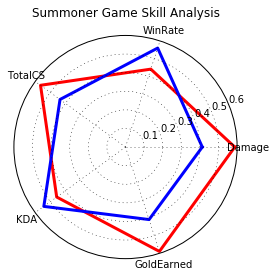

In [70]:
me, avg = [], []
key_list = ['Damage', 'WinRate', 'TotalCS', 'KDA', 'GoldEarned']
for key, value in filtered_data.iteritems():
    # normalize
    total = mean_temp[key] + value
    avg.append(mean_temp[key] / total)
    me.append(value / total)

avg.append(avg[0])
me.append(me[0])

theta = np.linspace(0, 2*np.pi, 6, endpoint=True)
r1 = np.array(me)
r2 = np.array(avg)
ax = plt.subplot(projection='polar')

ax.plot(theta, r1, color='r', linewidth=3)
ax.plot(theta, r2, color='b', linewidth=3)

ax.set_thetagrids(np.arange(0, 360, 360.0/5), labels=key_list)
ax.set_rmax(0.6)

ax.set_title("Summoner Game Skill Analysis", va='bottom')
plt.show()

#### <a name="s-analysis"></a>Summoner Analysis
##### Definition of KDA (Kill/Death/Assit)
KDA is a ratio factor revealing the survival and game ability of a summoner. The formula could be described as:
KDA = (#Kill + #Assist) / #Death

As a result, the higher KDA is, the better the summoner would be.

##### Analysis and Suggestions

The radar chart above displays five ability in all the game the summoner played in **Season 2016**. The **red** chart represents the summoner's data, and the **blue** one is the representation of average player in the same predicted tier (in this chart is tier Diamond, and all the data refers to ADC role). 

We have already pre-processing the data from per-session to per-game. As we can see in the chart, the summoner's total CS (minion kills) per game is higher than average, and so are the damage and gold earned. However, the summoner's KDA and win rate is lower than average.

The comparison shows that the summoner is able to obtain map resources fast, and always take advantage in lane confrontation and lane pushing. However, when it refers to group battle, especially for ADC role, the summoner should be more aware of the damage dealing position and survival. 

Lower KDA and lower winning rate than average might also reveals that the number of team fight engagement in one game is insufficient. League of Legends is a team strategic game, and if the summoner wants to win the game, he/she should group more and try to engage in team fight as much as possible.

#### <a name="champion-popularity"></a>Champion Popularity
With the data crawled, we can also visualize the popularities of all champions in LOL. Here, we used the word cloud library which is a very popular data visualization library. The code below will measure how frequently each champion is used in the games from the data we crawled, and it will draw a word cloud image to display the result.

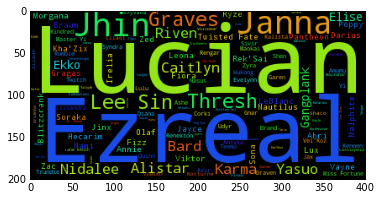

In [71]:
def count_champion(api_key):
    res = dict()
    file_names = glob.glob('./data/*.csv')
    for file_name in file_names:
        m = re.search(r'/(\d+)\.csv', file_name)
        if m:
            champion_id = m.group(1)
            req_url = 'https://global.api.pvp.net/api/lol/static-data/na/v1.2/champion/' \
                      + champion_id \
                      + '?api_key=' \
                      + api_key
            time.sleep(1)
            # print req_url
            data = urllib2.urlopen(req_url).read()
            json_data = json.loads(data)
            champion_name = json_data['name']
            with open(file_name) as f:
                champion_count = len(f.readlines())
                res[champion_name] = champion_count
            pass
        pass
    return res
    pass

if os.path.isfile('champion_popularity.pkl'):
    with open('champion_popularity.pkl', 'r+') as f:
        champion_counts = pickle.load(f)
        pass
    pass
else:
    champion_counts = count_champion(config['key'])
    with open('champion_popularity.pkl', 'w+') as f:
        pickle.dump(champion_counts, f, pickle.HIGHEST_PROTOCOL)
    pass

word_cloud = WordCloud().generate_from_frequencies(champion_counts.iteritems())
plt.imshow(word_cloud)
plt.show()